In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from numpy import asarray
from numpy import savez_compressed
from numpy import load
from tqdm import tqdm
from tensorflow.keras.callbacks import TensorBoard
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import  gray2rgb, rgb2gray
import matplotlib.pyplot as plt

In [2]:
dict_data=load('//content/drive/My Drive/INTERNSHIP 2020/datasets/CHIPDATASETS/akshay_data.npz')

X_train = dict_data['arr_0']
Y_train = dict_data['arr_1']
YY_train = dict_data['arr_2']
X_val = dict_data['arr_3']
Y_val = dict_data['arr_4']
X_test = dict_data['arr_5']


In [3]:
print(X_train.shape)
print(Y_train.shape)
print(YY_train.shape)
train_length = 28280
val_length = 5000
test_length = 5000

(28280, 128, 128, 3)
(28280, 128, 128, 1)
(28280, 128, 128, 1)


In [4]:
model1=tf.keras.models.load_model('/content/drive/My Drive/INTERNSHIP 2020/datasets/CHIPDATASETS/EdgeNetfinal.h5')
model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 16)      160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 1)       33        
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [5]:
model1.layers[0]._name='input_layer'
model1.layers[1]._name='Gaussian_layer'
model1.layers[2]._name='first'
model1.layers[3]._name='second'
model1.layers[4]._name='output_layer'

In [6]:
def sepConv(x,num_filter,strides=1):
  x=tf.keras.layers.DepthwiseConv2D(kernel_size=3,padding='same')(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  x=tf.keras.layers.Conv2D(num_filter,kernel_size=(1,1),padding='same',strides=strides)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  return x


In [7]:
def Conv(x,num_filter,kernel_size=3,strides=1):
  x=tf.keras.layers.Conv2D(num_filter,kernel_size=kernel_size,padding='same',strides=strides)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Activation('relu')(x)
  return x

In [8]:
def MobNet():
  inputs=tf.keras.layers.Input((128,128,3))
  x1=Conv(inputs,num_filter=32,kernel_size=3,strides=1)
  x1=sepConv(x1,num_filter=32,strides=1)       # 128*128*32
  # down_sample block 2
  x2=tf.keras.layers.MaxPool2D((2,2),(2,2))(x1)
  x2=Conv(x2,num_filter=64,kernel_size=3)
  x2=sepConv(x2,num_filter=64,strides=1)   # 64*64*64
  # down_sample block 3
  x3=tf.keras.layers.MaxPool2D((2,2),(2,2))(x2)
  x3=Conv(x3,num_filter=128,kernel_size=3)
  x3=sepConv(x3,num_filter=128)   #32*32*128
  #down_sample block 4
  x4=tf.keras.layers.MaxPool2D((2,2),(2,2))(x3)
  x4=Conv(x4,num_filter=256,kernel_size=1)
  x4=sepConv(x4,num_filter=256)  #16*16*256

  #down_sample block 5
  x5=tf.keras.layers.MaxPool2D((2,2),(2,2))(x4)
  x5=Conv(x5,num_filter=512,kernel_size=1)
  x5=sepConv(x5,num_filter=512)    # 8*8*512
  # up_sampling block 1
  u1=tf.keras.layers.UpSampling2D((2,2))(x5)
  u1=tf.keras.layers.Concatenate()([u1,x4]) # 16*16*(512+256)
  u1=Conv(u1,num_filter=256,kernel_size=1)
  u1=sepConv(u1,num_filter=256) # 16*16*256
  #upsampling_block 2
  u2=tf.keras.layers.UpSampling2D((2,2))(u1)
  u2=tf.keras.layers.Concatenate()([u2,x3])  # 32*32*(256+128)
  u2=Conv(u2,num_filter=128,kernel_size=1)
  u2=sepConv(u2,num_filter=128)   # 32*32*128
  # upsampling block 3
  u3=tf.keras.layers.UpSampling2D((2,2))(u2)
  u3=tf.keras.layers.Concatenate()([u3,x2])
  u3=Conv(u3,num_filter=64,kernel_size=1)
  u3=sepConv(u3,num_filter=64) # 64*64*64
  # upsampling block 4
  u4=tf.keras.layers.UpSampling2D((2,2))(u3)
  u4=tf.keras.layers.Concatenate()([u4,x1])
  u4=Conv(u4,num_filter=32)
  u4=sepConv(u4,num_filter=32) 
  outputs=tf.keras.layers.Conv2D(1,(1,1),padding='same',activation='sigmoid')(u4)
  
  
  model=tf.keras.models.Model(inputs,outputs)
  return model
   




In [9]:
l1,l2,l3=1,0.5,0.25


In [10]:
 #semenda loss_function implementation
def loss_fun(y_true,y_predict):
  y_true=tf.cast(y_true,tf.float32)
  y_predict=tf.cast(y_predict,tf.float32)
  
  
  # for layers 1  (128,128,16)
  layer_output1=model1.get_layer('first').output
  
  model_layer1=tf.keras.models.Model(inputs=model1.input,outputs=layer_output1)
  
  E1_hat=model_layer1(y_predict)
  E1=model_layer1(y_true)
  
  diff1=tf.keras.backend.abs(E1_hat-E1)
  
  # for layers 2 (128,128,32)
  layer_output2=model1.get_layer('second').output
  model_layer2=tf.keras.models.Model(inputs=model1.input,outputs=layer_output2)
  E2_hat=model_layer2(y_predict)
  E2=model_layer2(y_true)
  diff2=tf.keras.backend.abs(E2_hat-E2)
  

  #for output layer (128,128,1)
  E3_hat=model1(y_predict)
  E3=model1(y_true)
  diff3=tf.keras.backend.abs(E3_hat-E3)
  
  
  #total loss
  sum1=l1*tf.reduce_sum(diff1)  +l2*tf.reduce_sum(diff2)+l3*tf.reduce_sum(diff3)
  
  
  #sum2=tf.keras.losses.binary_crossentropy(y_true,y_predict)
  #sum2=tf.reduce_sum(sum2)+sum1

 
  return sum1

In [11]:
model=MobNet()
model.compile(optimizer='adam',loss=loss_fun,metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [12]:
hist1=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=32,epochs=25,validation_batch_size=20,callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/25
884/884 [==============================] - 507s 574ms/step - loss: 5375035.0000 - mean_io_u: 0.2804 - val_loss: 2895081.2500 - val_mean_io_u: 0.2842
Epoch 2/25
884/884 [==============================] - 505s 571ms/step - loss: 4083999.7500 - mean_io_u: 0.2804 - val_loss: 2648855.7500 - val_mean_io_u: 0.2850
Epoch 3/25
884/884 [==============================] - 504s 570ms/step - loss: 3697069.0000 - mean_io_u: 0.2817 - val_loss: 2666451.7500 - val_mean_io_u: 0.2869
Epoch 4/25
884/884 [==============================] - 504s 570ms/step - loss: 3472712.5000 - mean_io_u: 0.2855 - val_loss: 2231152.2500 - val_mean_io_u: 0.3117
Epoch 5/25
884/884 [==============================] - 505s 571ms/step - loss: 3317176.2500 - mean_io_u: 0.2937 - val_loss: 2118385.7500 - val_mean_io_u: 0.6008
Epoch 6/25
884/884 [==============================] - 503s 569ms/step - loss: 3179609.7500 - mean_io_u: 0.3221 - val_loss: 2012371.7500 - val_mean_io_u: 0.6693
Epoch 7/25
884/884 [====================

In [15]:
os.chdir('/content/drive/My Drive/INTERNSHIP 2020/datasets/CHIPDATASETS')

In [14]:
model.save('MobNetfinalwoth_only_semenda_loss.h5')

In [16]:
arr=X_train[3]
arr=tf.reshape(arr,(1,128,128,3))
print(arr.shape)

(1, 128, 128, 3)


In [17]:
Yhat=model.predict(arr)

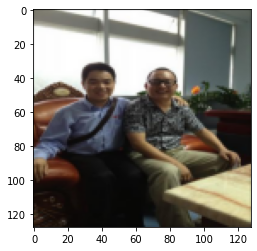

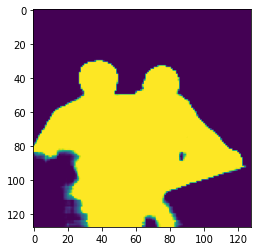

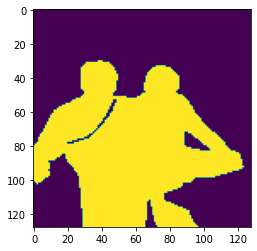

In [18]:
plt.imshow(arr[0])
plt.show()
plt.imshow(np.squeeze(Yhat[0]))
plt.show()
plt.imshow(np.squeeze(Y_train[3]))
plt.show()

In [19]:
arr=X_val[3]
arr=tf.reshape(arr,(1,128,128,3))
print(arr.shape)

(1, 128, 128, 3)


In [20]:
Yhat=model.predict(arr)

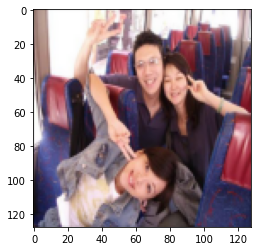

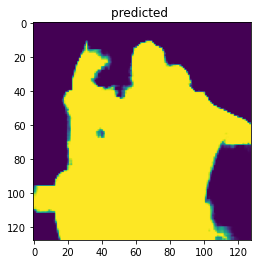

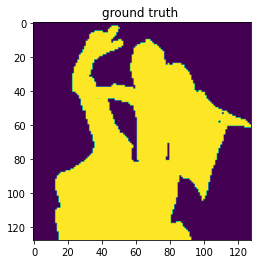

In [21]:
plt.imshow(arr[0])
plt.show()
plt.title('predicted ')
plt.imshow(np.squeeze(Yhat[0]))
plt.show()
plt.title('ground truth ')
plt.imshow(np.squeeze(Y_val[3]))
plt.show()

In [ ]:
#model2=tf.keras.models.load_model('/content/drive/My Drive/INTERNSHIP 2020/datasets/CHIPDATASETS/MobNetfinal.h5')

In [22]:
print(hist1.history.keys())

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])


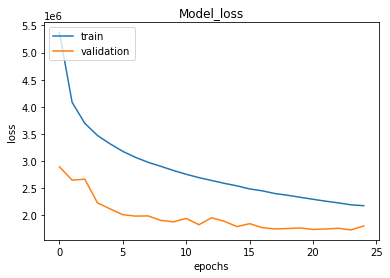

In [23]:
#summarize the loss of the model
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper left')
plt.show()


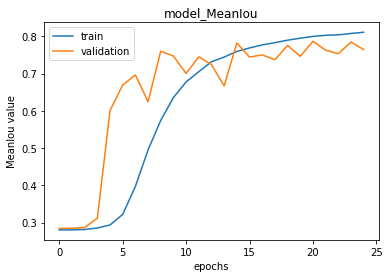

In [24]:
#summarize the
plt.title('model_MeanIou')
plt.plot(hist1.history['mean_io_u'])
plt.plot(hist1.history['val_mean_io_u'])
plt.xlabel('epochs')
plt.ylabel('MeanIou value')
plt.legend(['train','validation'],loc='upper left')
plt.show()

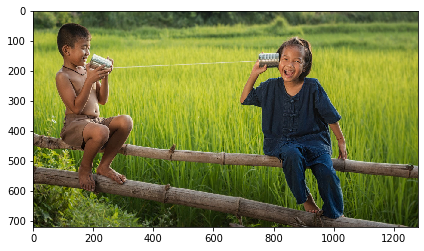

after resizing the image


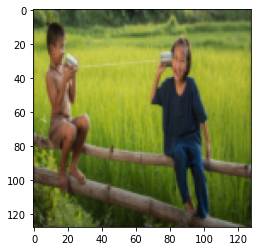

shape of the image: (1, 128, 128, 3)


In [25]:
# let's test the model prediction on other images outside the dataset
img=imread('/content/image_test.jpg')
imshow(img)
plt.show()
img=resize(img,(128,128),mode='constant',preserve_range=True)
print('after resizing the image')
img=tf.cast(img,dtype=np.uint8)
plt.imshow(img)
plt.show()
img=tf.reshape(img,(1,128,128,3))
print('shape of the image:',img.shape)



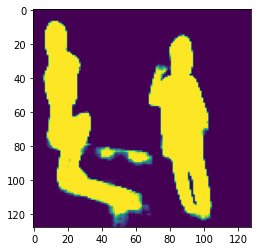

In [26]:
Yhat2=model.predict(img)
plt.imshow(np.squeeze(Yhat2[0]))